# Choose the MSM lag-time
quick MSM to check what a sensible lag-time would be


In [1]:
from msmbuilder.feature_extraction import AlphaAngleFeaturizer
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.preprocessing import RobustScaler
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import MiniBatchKMedoids
from msmbuilder.msm import MarkovStateModel
from msmbuilder.io import load_meta, preload_tops
from mdtraj import load

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pa

In [2]:
from glob import glob

top = '/Users/robert_arbon/Google Drive/Research/Hyperparameter_Optimisation/Code/Data/Villin/top_prot.pdb'
traj_paths = glob('/Users/robert_arbon/Google Drive/Research/Hyperparameter_Optimisation/Code/Data/Villin/*.xtc')

trajs = [load(traj, top=top) for traj in traj_paths]

In [3]:
ftrajs = AlphaAngleFeaturizer().fit_transform(trajs)
print(ftrajs[0].shape)

(1241, 64)


In [4]:
ftrajs = VarianceThreshold().fit_transform(ftrajs)
ftrajs = RobustScaler().fit_transform(ftrajs)

In [5]:
ttrajs = tICA(n_components=9, lag_time=44, kinetic_mapping=True).fit_transform(ftrajs)

In [6]:
import numpy as np
ctrajs = MiniBatchKMedoids(n_clusters=654, random_state=42).fit_transform(ttrajs)

In [7]:
quantiles = np.arange(50, 101, 10)
timescales = np.zeros((quantiles.shape[0], 5))
N = len(ctrajs)
for idx, quant in enumerate(quantiles):
    print(quant, end=', ')
    msm = MarkovStateModel(n_timescales=5, lag_time=100, verbose=True)
    q = int(N/100*quant)
    msm.fit(ctrajs[:q])
    timescales[idx] = msm.timescales_[:5]
    

50, MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%
60, MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%
70, MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%
80, MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%
90, MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%
100, MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%


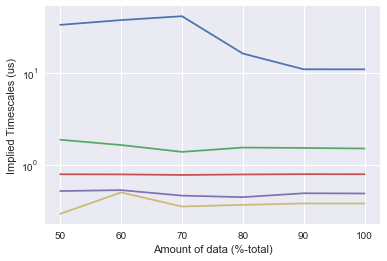

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
for i in range(5):
    plt.plot(quantiles, timescales.T[i]*0.5/1000)
    
plt.yscale('log')
plt.ylabel('Implied Timescales (us)')
plt.xlabel('Amount of data (%-total)')


In [ ]:
timescales